미니 프로젝트 코드 실습 순서

1. 비정상 데이터를 정상 데이터로 만들기
2. 분산을 일정하게 만들기 - log transformation
3. 차분을 통해 추세 제거하기
4. (추가) 계절 차분을 통해 계절성 제거하기
5. 검정을 통해 정상성 확인하기
6. 시계열 분류
    6-1. 데이터 다운로드 및 불러오기   
    6-2. 데이터셋 확인(timeseries와 y 확인)   
    6-3. 데이터셋 가공   
    6-4. 데이터셋 나누기   
    6-5. Feature extraction   
    6-6. impute   
    6-7. RandomForest 및 XGBoost 사용 및 score 확인   
    6-8. XGBoost plot_importance 확인 및 시각화   
    6-9. Classification report를 통한 검증 및 분석   

# ① 비정상 데이터를 정상 데이터로 만들기

In [ ]:
# LMS 사용시
# 먼저 데이터가 저장된 폴더를 연결합시다.
# !mkdir -p aiffel/time_series_basic
# !cp data/AirPassengers.csv aiffel/time_series_basic/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
file_path = '/content/drive/MyDrive/Colab Notebooks/14_time_series/AirPassengers.csv'

In [16]:
!pip install tsfresh

In [ ]:
# 라이브러리 버전 충돌을 피하기 위해 런타임을 재시작합니다.
import os
os.kill(os.getpid(), 9)

In [3]:
# 라이브러리를 불러옵니다.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# air passengers 데이터를 불러옵니다.
ap = pd.read_csv(file_path)

In [5]:
ap.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [6]:
ap.shape

(144, 2)

In [7]:
# 'Month' column을 삭제합니다.
ap = ap.drop('Month', axis=1)

In [8]:
ap

,#Passengers
0,112
1,118
2,132
3,129
4,121
...,...
139,606
140,508
141,461
142,390


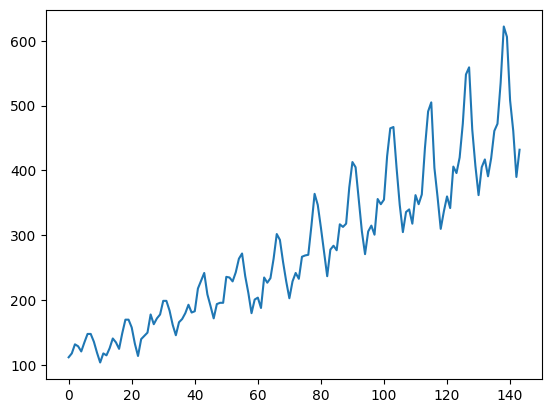

In [9]:
plt.figure()
plt.plot(ap)
plt.show()

# ② 분산을 일정하게 만들기 - log transformation

* log transformation을 하는 이유는 다음과 같습니다.
    - 큰 수를 같은비율의 작은 수로 만들 수 있습니다.
    - 복잡한 계산을 쉽게 만듭니다.
    - 왜도(skewness)와 첨도(kurtosis)를 줄여서 데이터 분석 시 의미있는 결과를 도출하기 위한 것입니다.

In [10]:
# np.log를 통해서 log transformation
log_transformed = np.log(ap['#Passengers'])

In [11]:
log_transformed

0      4.718499
1      4.770685
2      4.882802
3      4.859812
4      4.795791
         ...   
139    6.406880
140    6.230481
141    6.133398
142    5.966147
143    6.068426
Name: #Passengers, Length: 144, dtype: float64

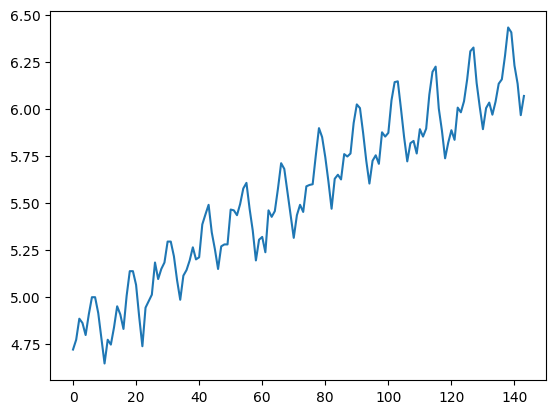

In [12]:
# 분산이 일정해진 것을 눈으로 확인할 수 있습니다.
plt.figure()
plt.plot(log_transformed)
plt.show()

# ③ 차분을 통해 추세 제거하기

In [13]:
# diff() 함수를 통해 간단하게 차분을 수행할 수 있습니다.
diffed = log_transformed.diff().dropna()

In [14]:
diffed

1      0.052186
2      0.112117
3     -0.022990
4     -0.064022
5      0.109484
         ...   
139   -0.026060
140   -0.176399
141   -0.097083
142   -0.167251
143    0.102279
Name: #Passengers, Length: 143, dtype: float64

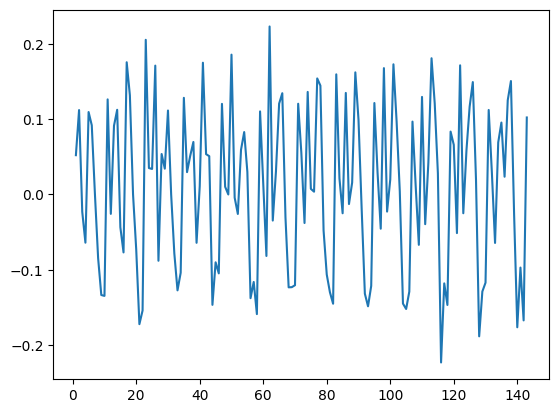

In [15]:
# 커지는 분산과 증가하는 추세를 제거한 air passengers 데이터를 얻을 수 있습니다.
plt.figure()
plt.plot(diffed)
plt.show()

# ④ (추가) 계절 차분을 통해 계절성 제거하기

AirPassengers 데이터는 12개월을 주기로 하는 계절성이 포함되어 있습니다. 이런 경우엔 계절 차분을 통해서 계절성을 데이터에서 제거할 수 있습니다.

In [16]:
# diff에 12라는 값을 넣어주면 주기를 12로 하는 계절 차분을 수행할 수 있습니다.
seasonally_diffed = diffed.diff(12)
# 차분을 하면 데이터가 짧아지기 때문에 빈칸을 제거해야 합니다.
seasonally_diffed.dropna(inplace = True)

In [17]:
# 형태를 확인해봅시다.
seasonally_diffed

13     0.039164
14     0.000361
15    -0.020496
16    -0.012939
17     0.066148
         ...   
139   -0.045934
140    0.012024
141    0.031830
142   -0.050082
143   -0.009964
Name: #Passengers, Length: 131, dtype: float64

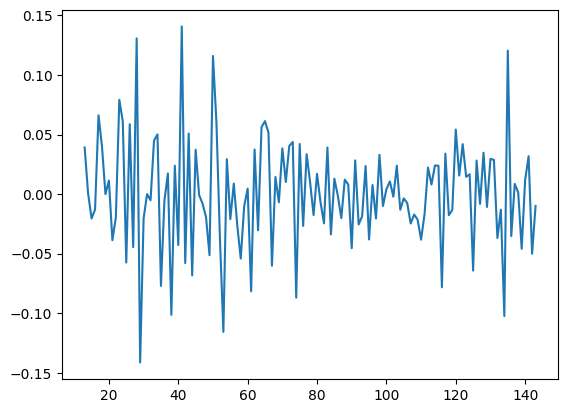

In [18]:
# 아래와 같은 데이터를 얻을 수 있습니다.
plt.figure()
plt.plot(seasonally_diffed)
plt.show()

# ⑤ 검정을 통해 정상성 확인하기

* adfuller : Python에서 statsmodels을 통해 ADF(Augmented Dickey-Fuller) Test를 할 수 있습니다. 앞서 Classification report를 통해 Logistic Regression 모델을 검증한 것과 마찬가지로 시계열 데이터를 통계 분석하고 검증할 때 사용합니다. adfuller를 사용하면 대표적으로 다음과 같은 값을 얻을 수 있습니다.
    - adf(단위근 검정, Augmented Dickey Fuller) : 정상성을 확인하기 위한 단위근 검정방법
    - p-value(유의 검정) : 관찰된 데이터가 귀무가설이 맞다면 통계값 1이 실제로 관측된 값 이상일 확률
    - usedlag : 사용된 시차의 수
    - nobs : ADF 회귀 및 임계값 계산에 사용된 관측치의 수
    - critical values(임계값) : 1%, 5% 및 10% 수준에서 테스트 통계에 대한 임계값
    - icbest : 0, 1, …, maxlag 값 중 lag 길이를 자동으로 결정할 때 autolag를 사용하며 이때 autolag를 none으로 지정할 수 있는데 none으로 지정하지 않는 경우 최대화된 정보 기준

In [19]:
from statsmodels.tsa.stattools import adfuller

def adf_test(x): # adf검정을 위한 함수 정의
    stat, p_value, lags, nobs, crit, icb = adfuller(x) # adfuller 함수를 이용하면 6가지 output이 나옵니다.
    print('ADF statistics')
    print(stat)
    print('P-value')
    print(p_value)

In [20]:
# 계절차분까지 수행한 데이터로 adf 테스트를 수행합니다.
adf_test(seasonally_diffed)

ADF statistics
-4.4433249418311425
P-value
0.00024859123113838495


* p-value가 0.05보다 작기 때문에 H0(해당 시계열이 단위근을 갖고 있다--> 비정상성)를 기각함
* 따라서 해당 시계열이 정상성을 가졌을 가능성이 매우 높음

# ⑥ 시계열 분류

강의 때 Logistic Regression을 이용한 시계열 분류가 낮은 score를 보였습니다. 앙상블 모델과 더 많은 특징을 활용해서 분류 성능을 높여봅시다!

## ⑥-1 : 데이터 다운로드 및 불러오기

In [43]:
# ⑥-1 : 데이터 다운로드 및 불러오기
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures

# robot exection failures 데이터를 불러옵니다.
download_robot_execution_failures()
timeseries, y = load_robot_execution_failures()

## ⑥-2 : 데이터셋 확인(timeseries와 y 확인)

In [44]:
# ⑥-2 : 데이터셋 확인(timeseries와 y 확인)
timeseries # id, time을 제외하고 6개 column의 X변수가 나타납니다.

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0
...,...,...,...,...,...,...,...,...
1315,88,10,-10,2,39,-21,-24,5
1316,88,11,-11,2,38,-24,-22,6
1317,88,12,-12,3,23,-24,-24,5
1318,88,13,-13,4,26,-29,-27,5


In [45]:
y # true/false가 제시되어 있습니다.

1      True
2      True
3      True
4      True
5      True
      ...  
84    False
85    False
86    False
87    False
88    False
Length: 88, dtype: bool

In [46]:
ts_df = timeseries.drop(['id', 'time'], axis=1)
ts_df

,F_x,F_y,F_z,T_x,T_y,T_z
0,-1,-1,63,-3,-1,0
1,0,0,62,-3,-1,0
2,-1,-1,61,-3,0,0
3,-1,-1,63,-2,-1,0
4,-1,-1,63,-3,-1,0
...,...,...,...,...,...,...
1315,-10,2,39,-21,-24,5
1316,-11,2,38,-24,-22,6
1317,-12,3,23,-24,-24,5
1318,-13,4,26,-29,-27,5


## ⑥-3 : 데이터셋 가공

In [47]:
# ⑥-3 : 데이터셋 가공
def custom_classification_split(x,y,test_size=0.3): # 수업 때 보았던 custom split 함수

    num_true = int(y.sum()*test_size)
    num_false = int((len(y)-y.sum())*test_size)

    id_list = y[y==False].head(num_false).index.to_list() + y[y==True].head(num_true).index.to_list()

    y_train = y.drop(id_list)
    y_test = y.iloc[id_list].sort_index()
    X_train = x[~x['id'].isin(id_list)]
    X_test = x[x['id'].isin(id_list)]

    return X_train, y_train, X_test, y_test

## ⑥-4 : 데이터셋 나누기

In [48]:
# custom split 함수 정의
def custom_classification_split(x, y, test_size=0.3):
    num_true = int(y.sum() * test_size)           # int(21 * 0.3) = 6
    num_false = int((len(y)-y.sum()) * test_size) # int((88-21)*0.3) = 20

    id_list = y[y==False].head(num_false).index.to_list() + y[y==True].head(num_true).index.to_list()
    # y==False인 것과 y==True인 것의 인덱스값을 리스트로 변환하여 더해줍니다.
    # y[y==False].head(num_false).index.to_list()는 19-38까지의 값이 리스트로
    # y[y==True].head(num_true).index.to_list()는 1-6까지의 값이 리스트로
    # id_list는 20-39 + 2-7이 더해진 리스트입니다.

    y_train = y.drop(id_list)              # y에서 id_list를 drop합니다
    y_test = y.iloc[id_list].sort_index()  # 20-39, 2-7이 합쳐진 리스트를 정렬합니다.
    X_train = x[~x['id'].isin(id_list)]    # 대괄호 안에 있는 timeseries의 id와 id_list가 일치하는 것만 사용합니다.
    X_test = x[x['id'].isin(id_list)]      # timeseries의 id와 id_list가 일치하는 것만 사용해서 timeseries에 적용

    return X_train, y_train, X_test, y_test

In [49]:
# ⑥-4 : 데이터셋 나누기
# test set의 비율을 0.25로 지정해주세요.
X_train, y_train, X_test, y_test = custom_classification_split(timeseries, y, test_size=0.25)

In [50]:
# 커스텀한 함수를 적용한 데이터셋이 어떤 차이가 있는지 확인해봅시다
X_train, y_train, X_test, y_test = custom_classification_split(timeseries, y)

print(X_train)
print('-'*50)
print(y_train)
print('-'*50)
print(X_test)
print('-'*50)
print(y_test)

      id  time  F_x  F_y  F_z  T_x  T_y  T_z
90     7     0   -3    1   53  -10   -4    0
91     7     1    0   -2   65   -4   -1    0
92     7     2   -1   -1   56   -7   -3    0
93     7     3    0   -2   60   -6    0    0
94     7     4   -1   -1   57   -7   -4    0
...   ..   ...  ...  ...  ...  ...  ...  ...
1315  88    10  -10    2   39  -21  -24    5
1316  88    11  -11    2   38  -24  -22    6
1317  88    12  -12    3   23  -24  -24    5
1318  88    13  -13    4   26  -29  -27    5
1319  88    14  -13    2   15  -25  -25    6

[930 rows x 8 columns]
--------------------------------------------------
7      True
8      True
9      True
10     True
11     True
      ...  
84    False
85    False
86    False
87    False
88    False
Length: 62, dtype: bool
--------------------------------------------------
     id  time  F_x  F_y  F_z  T_x  T_y  T_z
0     1     0   -1   -1   63   -3   -1    0
1     1     1    0    0   62   -3   -1    0
2     1     2   -1   -1   61   -3    0    0
3 

## ⑥-5 : Feature extraction

In [51]:
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute

settings = EfficientFCParameters()

In [52]:
# ⑥-5 : Feature extraction
efficient_features_train = extract_features(
                                    X_train,
                                    column_id="id",
                                    column_sort="time",
                                    default_fc_parameters=settings
                                          )

Feature Extraction: 100%|██████████| 372/372 [00:24<00:00, 14.96it/s]


In [53]:
efficient_features_test = extract_features(
                                    X_test,
                                    column_id="id",
                                    column_sort="time",
                                    default_fc_parameters=settings
                                          )

Feature Extraction: 100%|██████████| 156/156 [00:08<00:00, 17.99it/s]


In [54]:
efficient_features_train.shape, efficient_features_test.shape

((62, 4662), (26, 4662))

In [55]:
# 추출된 특징 확인
efficient_features_train

,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
7,0.0,1.0,0.0,1.0,-13.0,21.0,0.928571,0.214286,-0.076923,-1.0,...,1.255482,1.494175,2.079442,1.043794,1.349792,1.666333,1.748067,1.831020,NaN,0.428571
8,1.0,0.0,1.0,1.0,-10.0,26.0,1.142857,-0.142857,0.192308,-1.0,...,1.494175,1.732868,2.079442,1.412745,2.138333,2.397895,2.302585,2.197225,NaN,1.285714
9,1.0,0.0,0.0,1.0,-10.0,24.0,1.428571,0.000000,-0.076923,-1.0,...,1.255482,1.494175,2.079442,1.479133,2.138333,2.397895,2.302585,2.197225,NaN,1.285714
10,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.000000,0.000000,-1.0,...,NaN,NaN,NaN,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,NaN,0.000000
11,0.0,0.0,0.0,1.0,-13.0,25.0,1.285714,0.000000,0.000000,-1.0,...,0.735622,1.073543,1.906155,0.535961,0.836988,0.885574,0.940448,1.002718,NaN,0.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,1.0,1.0,0.0,1.0,-1073.0,96833.0,7.142857,-5.428571,-0.038462,-98.0,...,0.735622,0.735622,1.386294,1.585771,2.253858,2.397895,2.302585,2.197225,NaN,24.285714
85,1.0,0.0,1.0,1.0,143.0,1683.0,1.357143,1.071429,0.076923,8.0,...,0.735622,0.735622,1.667462,1.332245,1.589027,1.893788,2.163956,2.197225,NaN,5.571429
86,1.0,0.0,0.0,0.0,961.0,83497.0,9.071429,9.071429,0.807692,52.0,...,0.735622,1.073543,1.732868,0.687092,0.983088,1.159589,1.227529,1.303092,NaN,9.285714
87,1.0,1.0,0.0,1.0,4509.0,1405437.0,12.928571,12.214286,-1.038462,338.0,...,0.735622,0.735622,1.386294,0.535961,0.836988,1.159589,1.497866,1.581094,NaN,40.285714


In [56]:
efficient_features_test

,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
1,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.000000,-0.038462,-1.0,...,NaN,NaN,NaN,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,NaN,0.000000
2,0.0,1.0,1.0,1.0,-13.0,25.0,1.000000,0.000000,-0.038462,-1.0,...,1.073543,1.494175,2.079442,0.937156,1.234268,1.540306,1.748067,1.831020,NaN,0.571429
3,0.0,0.0,1.0,1.0,-10.0,12.0,0.714286,0.000000,-0.038462,-1.0,...,1.386294,1.732868,2.079442,1.265857,1.704551,2.019815,2.163956,2.197225,NaN,0.571429
4,0.0,1.0,1.0,1.0,-6.0,16.0,1.214286,-0.071429,-0.038462,0.0,...,1.073543,1.494175,2.079442,1.156988,1.907284,2.397895,2.302585,2.197225,NaN,1.000000
5,0.0,0.0,0.0,1.0,-9.0,17.0,0.928571,-0.071429,0.038462,-1.0,...,0.900256,1.320888,2.079442,1.156988,1.863680,2.271869,2.302585,2.197225,NaN,0.857143
6,1.0,1.0,1.0,1.0,-15.0,39.0,1.714286,0.142857,0.153846,-1.0,...,0.974315,1.213008,1.732868,1.438883,1.863680,2.145842,2.163956,2.197225,NaN,0.714286
19,1.0,0.0,0.0,1.0,99.0,6109.0,13.928571,-1.928571,-1.730769,1.0,...,0.974315,1.494175,1.906155,1.230932,1.704551,2.019815,2.025326,2.043192,NaN,1.428571
20,1.0,0.0,1.0,1.0,155.0,34455.0,16.714286,-13.142857,7.576923,-1.0,...,1.386294,1.667462,2.079442,1.564957,2.022809,2.271869,2.302585,2.197225,NaN,2.571429
21,1.0,0.0,0.0,1.0,-171.0,16495.0,20.928571,1.785714,3.961538,-1.0,...,0.735622,0.735622,0.735622,1.303876,1.791759,2.271869,2.302585,2.197225,NaN,17.285714
22,1.0,0.0,0.0,1.0,102.0,12700.0,10.785714,-8.071429,4.500000,-1.0,...,0.562335,0.735622,1.732868,1.524707,2.138333,2.397895,2.302585,2.197225,NaN,5.428571


In [57]:
efficient_features_train.columns

Index(['F_x__variance_larger_than_standard_deviation',
       'F_x__has_duplicate_max', 'F_x__has_duplicate_min',
       'F_x__has_duplicate', 'F_x__sum_values', 'F_x__abs_energy',
       'F_x__mean_abs_change', 'F_x__mean_change',
       'F_x__mean_second_derivative_central', 'F_x__median',
       ...
       'T_z__fourier_entropy__bins_5', 'T_z__fourier_entropy__bins_10',
       'T_z__fourier_entropy__bins_100',
       'T_z__permutation_entropy__dimension_3__tau_1',
       'T_z__permutation_entropy__dimension_4__tau_1',
       'T_z__permutation_entropy__dimension_5__tau_1',
       'T_z__permutation_entropy__dimension_6__tau_1',
       'T_z__permutation_entropy__dimension_7__tau_1',
       'T_z__query_similarity_count__query_None__threshold_0.0',
       'T_z__mean_n_absolute_max__number_of_maxima_7'],
      dtype='object', length=4662)

## ⑥-6 : impute

In [58]:
# ⑥-6 : impute
impute(efficient_features_train)

/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
7,0.0,1.0,0.0,1.0,-13.0,21.0,0.928571,0.214286,-0.076923,-1.0,...,1.255482,1.494175,2.079442,1.043794,1.349792,1.666333,1.748067,1.831020,0.0,0.428571
8,1.0,0.0,1.0,1.0,-10.0,26.0,1.142857,-0.142857,0.192308,-1.0,...,1.494175,1.732868,2.079442,1.412745,2.138333,2.397895,2.302585,2.197225,0.0,1.285714
9,1.0,0.0,0.0,1.0,-10.0,24.0,1.428571,0.000000,-0.076923,-1.0,...,1.255482,1.494175,2.079442,1.479133,2.138333,2.397895,2.302585,2.197225,0.0,1.285714
10,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.000000,0.000000,-1.0,...,0.900256,1.213008,1.906155,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.0,0.000000
11,0.0,0.0,0.0,1.0,-13.0,25.0,1.285714,0.000000,0.000000,-1.0,...,0.735622,1.073543,1.906155,0.535961,0.836988,0.885574,0.940448,1.002718,0.0,0.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,1.0,1.0,0.0,1.0,-1073.0,96833.0,7.142857,-5.428571,-0.038462,-98.0,...,0.735622,0.735622,1.386294,1.585771,2.253858,2.397895,2.302585,2.197225,0.0,24.285714
85,1.0,0.0,1.0,1.0,143.0,1683.0,1.357143,1.071429,0.076923,8.0,...,0.735622,0.735622,1.667462,1.332245,1.589027,1.893788,2.163956,2.197225,0.0,5.571429
86,1.0,0.0,0.0,0.0,961.0,83497.0,9.071429,9.071429,0.807692,52.0,...,0.735622,1.073543,1.732868,0.687092,0.983088,1.159589,1.227529,1.303092,0.0,9.285714
87,1.0,1.0,0.0,1.0,4509.0,1405437.0,12.928571,12.214286,-1.038462,338.0,...,0.735622,0.735622,1.386294,0.535961,0.836988,1.159589,1.497866,1.581094,0.0,40.285714


In [59]:
impute(efficient_features_test)

/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
1,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.000000,-0.038462,-1.0,...,1.073543,1.320888,1.906155,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.0,0.000000
2,0.0,1.0,1.0,1.0,-13.0,25.0,1.000000,0.000000,-0.038462,-1.0,...,1.073543,1.494175,2.079442,0.937156,1.234268,1.540306,1.748067,1.831020,0.0,0.571429
3,0.0,0.0,1.0,1.0,-10.0,12.0,0.714286,0.000000,-0.038462,-1.0,...,1.386294,1.732868,2.079442,1.265857,1.704551,2.019815,2.163956,2.197225,0.0,0.571429
4,0.0,1.0,1.0,1.0,-6.0,16.0,1.214286,-0.071429,-0.038462,0.0,...,1.073543,1.494175,2.079442,1.156988,1.907284,2.397895,2.302585,2.197225,0.0,1.000000
5,0.0,0.0,0.0,1.0,-9.0,17.0,0.928571,-0.071429,0.038462,-1.0,...,0.900256,1.320888,2.079442,1.156988,1.863680,2.271869,2.302585,2.197225,0.0,0.857143
6,1.0,1.0,1.0,1.0,-15.0,39.0,1.714286,0.142857,0.153846,-1.0,...,0.974315,1.213008,1.732868,1.438883,1.863680,2.145842,2.163956,2.197225,0.0,0.714286
19,1.0,0.0,0.0,1.0,99.0,6109.0,13.928571,-1.928571,-1.730769,1.0,...,0.974315,1.494175,1.906155,1.230932,1.704551,2.019815,2.025326,2.043192,0.0,1.428571
20,1.0,0.0,1.0,1.0,155.0,34455.0,16.714286,-13.142857,7.576923,-1.0,...,1.386294,1.667462,2.079442,1.564957,2.022809,2.271869,2.302585,2.197225,0.0,2.571429
21,1.0,0.0,0.0,1.0,-171.0,16495.0,20.928571,1.785714,3.961538,-1.0,...,0.735622,0.735622,0.735622,1.303876,1.791759,2.271869,2.302585,2.197225,0.0,17.285714
22,1.0,0.0,0.0,1.0,102.0,12700.0,10.785714,-8.071429,4.500000,-1.0,...,0.562335,0.735622,1.732868,1.524707,2.138333,2.397895,2.302585,2.197225,0.0,5.428571


## ⑥-7 : RandomForest 사용 및 score 확인

In [88]:
# ⑥-7 : RandomForest 사용 및 score 확인
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators = 10, max_depth = 3)

rf_clf.fit(efficient_features_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10)

In [89]:
# test셋에 적합해본 결과 약 0.66의 정확도를 보이며 불만족스러운 결과를 확인할 수 있습니다.
rf_clf.score(efficient_features_test, y_test)

0.9615384615384616

## ⑥-7 : XGBoost 사용 및 score 확인

In [125]:
# ⑥-7 : XGBoost 사용 및 score 확인
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(n_estimators = 10, max_depth = 3)

# XGBoost 모델을 학습시킵니다.
xgb_clf.fit(efficient_features_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [126]:
# XGBoost 모델의 score를 확인합니다.
xgb_clf.score(efficient_features_test, y_test)

1.0

-> overfitting 의심!!!

In [117]:
# Fit the model with early stopping and regularization
xgb_clf_v2 = xgb.XGBClassifier(
    n_estimators=10,           # More trees can help generalization, use early stopping to control overfitting
    max_depth=2,               # Control the depth of trees
    learning_rate=0.01,        # Lower learning rate for better generalization
    subsample=0.8,             # Subsample ratio of training data
    colsample_bytree=0.8,      # Subsample ratio of features
    random_state=42
)

In [118]:
# XGBoost 모델을 학습시킵니다.
xgb_clf_v2.fit(efficient_features_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [119]:
# XGBoost 모델의 score를 확인합니다.
xgb_clf_v2.score(efficient_features_test, y_test)

0.7692307692307693

## ⑥-7 : Logistic Regression

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Logistic Regression 사용하기
logistic = LogisticRegression()
logistic.fit(efficient_features_train, y_train)

LogisticRegression()

In [80]:
# Logistic Regression score 확인하기
logistic.score(efficient_features_test, y_test)

0.5384615384615384

## ⑥-8 : XGBoost plot_importance 확인 및 시각화

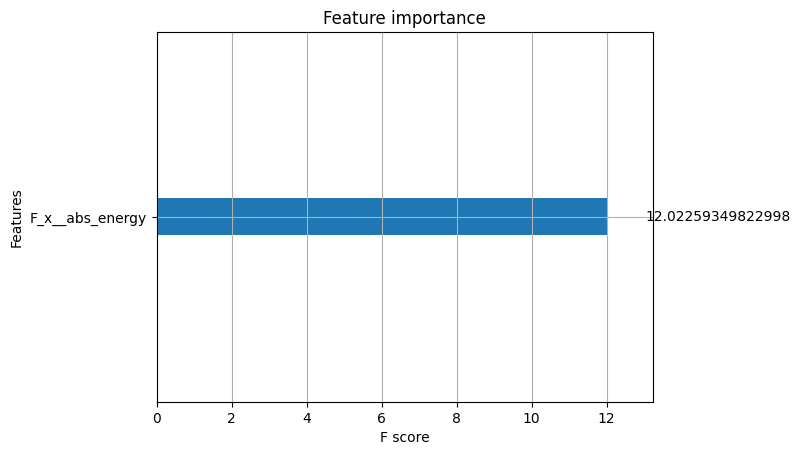

In [82]:
# ⑥-8 : XGBoost plot_importance 확인 및 시각화
# plot_importance를 통해 어떤 변수(특징)가 가장 유의미한지 확인합니다.
xgb.plot_importance(xgb_clf, importance_type = 'gain')
plt.show()

In [83]:
sum(xgb_clf.feature_importances_ != 0) # Fx 값의 abs_energy 특징만의 유의미함

1

## ⑥-9 : Classification report를 통한 검증 및 분석

In [129]:
# ⑥-9 : Classification report를 통한 검증 및 분석 - Random Forest Classifier
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, rf_clf.predict(efficient_features_test)))
print(classification_report(y_test, rf_clf.predict(efficient_features_test), target_names = ['true', 'false'], output_dict = True))

[[19  1]
 [ 0  6]]
{'true': {'precision': 1.0, 'recall': 0.95, 'f1-score': 0.9743589743589743, 'support': 20}, 'false': {'precision': 0.8571428571428571, 'recall': 1.0, 'f1-score': 0.923076923076923, 'support': 6}, 'accuracy': 0.9615384615384616, 'macro avg': {'precision': 0.9285714285714286, 'recall': 0.975, 'f1-score': 0.9487179487179487, 'support': 26}, 'weighted avg': {'precision': 0.967032967032967, 'recall': 0.9615384615384616, 'f1-score': 0.962524654832347, 'support': 26}}


In [127]:
# ⑥-9 : Classification report를 통한 검증 및 분석 - XGBoost

print(confusion_matrix(y_test, xgb_clf.predict(efficient_features_test)))
print(classification_report(y_test, xgb_clf.predict(efficient_features_test), target_names = ['true', 'false'], output_dict = True))

[[20  0]
 [ 0  6]]
{'true': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 20}, 'false': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 6}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 26}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 26}}


In [128]:
# ⑥-9 : Classification report를 통한 검증 및 분석 - XGBoost with different parameters

print(confusion_matrix(y_test, xgb_clf_v2.predict(efficient_features_test)))
print(classification_report(y_test, xgb_clf_v2.predict(efficient_features_test), target_names = ['true', 'false'], output_dict = True))

[[20  0]
 [ 6  0]]
{'true': {'precision': 0.7692307692307693, 'recall': 1.0, 'f1-score': 0.8695652173913044, 'support': 20}, 'false': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6}, 'accuracy': 0.7692307692307693, 'macro avg': {'precision': 0.38461538461538464, 'recall': 0.5, 'f1-score': 0.4347826086956522, 'support': 26}, 'weighted avg': {'precision': 0.591715976331361, 'recall': 0.7692307692307693, 'f1-score': 0.6688963210702342, 'support': 26}}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [130]:
# ⑥-9 : Classification report를 통한 검증 및 분석

print(confusion_matrix(y_test, logistic.predict(efficient_features_test)))
print(classification_report(y_test, logistic.predict(efficient_features_test), target_names = ['true', 'false'], output_dict = True))

[[ 8 12]
 [ 0  6]]
{'true': {'precision': 1.0, 'recall': 0.4, 'f1-score': 0.5714285714285715, 'support': 20}, 'false': {'precision': 0.3333333333333333, 'recall': 1.0, 'f1-score': 0.5, 'support': 6}, 'accuracy': 0.5384615384615384, 'macro avg': {'precision': 0.6666666666666666, 'recall': 0.7, 'f1-score': 0.5357142857142858, 'support': 26}, 'weighted avg': {'precision': 0.8461538461538461, 'recall': 0.5384615384615384, 'f1-score': 0.554945054945055, 'support': 26}}
